# **Facial Keypoint Detection using PyTorch and VGG16**

## **Introduction**
This project is all about **detecting facial keypoints** using deep learning. 
The goal is to take an image of a face and predict 68 keypoints that define its features eyes, nose, lips, and jawline. 
This kind of technology is used in facial recognition, augmented reality (AR), and medical diagnostics.

I have chosen **VGG16**, a pre-trained deep learning model, as my backbone to extract features from facial images. 
Then, I modify its classifier to predict keypoint locations instead of class labels.

### **What I’ve Learned So Far**
1. **How facial keypoints are structured** - 68 points define critical facial landmarks.
2. **Why pre-trained models are useful** - VGG16 already understands image features, so I only need to fine-tune it.
3. **How to handle image data in PyTorch** - Creating custom datasets and processing images.
4. **Why keypoint normalization is important** - So the model can generalize across different image sizes.
5. **How to visualize keypoints** - Overlaying predictions on images to evaluate performance.



## **Project Steps**
To train our model, we will follow these steps:

1. **Load and Prepare the Data**  
   - Read the dataset, which contains images and corresponding facial keypoints.
   - Organize data into training and testing sets.

2. **Build a Custom Dataset Class**  
   - Load images and preprocess them.
   - Normalize keypoints to keep them consistent across different image sizes.
   - Ensure images are in the correct format for PyTorch models.

3. **Create DataLoaders for Training and Testing**  
   - Convert dataset into batches for efficient training.
   - Use `shuffle=True` in training to prevent overfitting.

4. **Modify a Pre-Trained VGG16 Model**  
   - Remove the original classifier meant for object classification.
   - Replace it with fully connected layers for keypoint prediction.
   - Freeze convolutional layers to keep pre-trained feature extraction.

5. **Train the Model**  
   - Define the **loss function (L1 Loss)** since this is a regression problem.
   - Use the **Adam optimizer** to update model weights efficiently.
   - Train for multiple epochs while tracking loss.

6. **Evaluate the Model**  
   - Test on unseen images.
   - Compare predicted keypoints with ground truth.
   - Display random test images with predicted keypoints.
   - Check if the model is learning meaningful patterns.

7. **Saving the Trained Model**  
   - Save trained model weights for future use.
   

8. **Loading the Saved Model for Inference**  
   
   - Load the saved model and test it again.

Lets being by loading supporting libraries first 

In [1]:
# Import Required Libraries
import torch  # PyTorch for deep learning
import torchvision  # TorchVision for pre-trained models and transformations
import torch.nn as nn  # Neural network modules
from torchvision import transforms, models, datasets  # Image processing utilities
from torch.utils.data import DataLoader, Dataset  # Data handling utilities

# Additional Libraries
import numpy as np  # Numerical operations
import pandas as pd  # Handling CSV files
import cv2  # OpenCV for image processing
import matplotlib.pyplot as plt  # Visualization
import random  # For random sampling of test images
from tqdm import tqdm  # For progress bars

# Detect device (GPU or CPU) and assign it to 'device' variable
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


## **Step 1: Load and Prepare the Data**

### **Why This Step?**
Before training a model, we need data. Our dataset consists of:
- **Facial images** (grayscale or RGB).
- **Facial keypoints** (68 x, y coordinates for different facial features).
- A CSV file that maps **each image to its keypoints**.

The goal here is to **load this dataset into a structured format** that we can use for deep learning.

### **What I’ve Learned So Far**
1. **How datasets are structured** - Images and keypoints are stored separately, and keypoints need to be aligned with the correct image.
2. **How to use Pandas to read CSV files** - CSVs are easy to manage but need cleaning.
3. **How file paths are used in datasets** - Images are stored in folders, and their paths need to be reconstructed.

In [2]:
# Define dataset paths
train_images_root = "data/training"
train_df_root = "data/training_frames_keypoints.csv"
test_images_root = "data/test"
test_df_root = "data/test_frames_keypoints.csv"

# Load CSV files
train_df = pd.read_csv(train_df_root)
test_df = pd.read_csv(test_df_root)

# Display first few rows to verify
display(train_df.head(), test_df.head())


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,James_Wolfensohn_00.jpg,25.0,44.0,25.0,49.0,25.0,54.0,25.0,59.0,26.0,...,42.0,65.0,46.0,65.0,42.0,65.0,39.0,65.0,38.0,65.0
1,Valerie_Harper_30.jpg,55.0,62.0,52.0,72.0,52.0,83.0,55.0,90.0,55.0,...,78.0,104.0,88.0,106.0,78.0,106.0,75.0,104.0,70.0,104.0
2,Kristen_Breitweiser_11.jpg,60.0,88.0,60.0,98.0,63.0,109.0,65.0,116.0,68.0,...,96.0,114.0,106.0,117.0,96.0,117.0,94.0,117.0,89.0,117.0
3,Elizabeth_Dole_31.jpg,41.0,96.0,43.0,104.0,47.0,113.0,49.0,120.0,56.0,...,98.0,118.0,103.0,118.0,98.0,120.0,96.0,122.0,94.0,122.0
4,Kit_Bond_20.jpg,35.0,67.0,37.0,74.0,41.0,81.0,44.0,87.0,48.0,...,76.0,96.0,83.0,93.0,76.0,98.0,73.0,98.0,69.0,98.0


## **Step 2: Build a Custom Dataset Class**

### **Why This Step?**
Deep learning models in PyTorch don’t work directly with CSV files. We need a structured **Dataset class** that:
- **Loads images** from disk.
- **Extracts facial keypoints** from the CSV.
- **Processes images and keypoints** into a format that the model can use.

This class ensures that every image and its corresponding keypoints are correctly paired and transformed before training.

---

### **What I’ve Learned So Far**
1. **How PyTorch's `Dataset` class works** - This allows us to create a structured dataset for training.
2. **Why we need to resize images** - Deep learning models need fixed-size inputs (224×224 in this case).
3. **Why we normalize keypoints** - Scaling ensures that keypoints remain relative across different image sizes.
4. **How to load images dynamically** - Instead of loading everything into memory at once, we load only when needed.

---

### **How Image Filenames Are Extracted**
Each row in the CSV contains:
- **Column 0** → Image filename
- **Columns 1-136** → Keypoint coordinates (x1, y1, x2, y2, …, x68, y68)

Example of `train_df`:
| image_name      | x1   | y1   | x2   | y2   | ... | x68  | y68  |
|----------------|------|------|------|------|-----|------|------|
| image_001.jpg  | 120  | 80   | 130  | 85   | ... | 200  | 160  |
| image_002.jpg  | 95   | 72   | 105  | 78   | ... | 185  | 150  |

From this, we extract:
```python
img_path = f"{self.root_dir}/{self.df.iloc[ix, 0]}"  # Example: "data/training/image_001.jpg"


### **Why We Normalize Keypoints**
If we don’t normalize, keypoints will be in **absolute pixel values**, which vary depending on the image size. This means that the same facial feature in a **larger image** would have **higher numerical values** compared to a **smaller image**, even though both images represent the same face.

To make keypoints **scale-independent**, we **normalize** them by dividing:
- **X-coordinates** by the image width.
- **Y-coordinates** by the image height.

#### **Normalization Formula**
```python
key_points[0::2] /= img.shape[1]  # Normalize x-coordinates
key_points[1::2] /= img.shape[0]  # Normalize y-coordinates


### **Example: Before and After Normalization**

#### **Image Dimensions**: 500px (Width) × 400px (Height)

| **Keypoint Type**       | **Values**                      |
|------------------------|--------------------------------|
| **Original Keypoints** | `x1 = 250, y1 = 200, x2 = 300, y2 = 220` |
| **After Normalization** | `x1 = 0.50, y1 = 0.50, x2 = 0.60, y2 = 0.55` |


### **Why This Matters**
- The **keypoints remain within a 0-1 range**, regardless of the image size.
- The model **learns relative positions** instead of absolute pixel values.
- It **improves generalization**, allowing the model to work on different image resolutions.
- By normalizing keypoints, we ensure that our model **understands facial structures in a scale-invariant manner**, leading to **better accuracy and robustness**.


In [3]:
class FacialKp(Dataset):
    def __init__(self, df, root_dir, device):
        """
        Custom Dataset class for Facial Keypoints detection.

        Args:
            df (DataFrame): Pandas DataFrame containing image filenames and keypoints.
            root_dir (str): Directory where images are stored.
            device (str): Device (CPU/GPU) to move tensors.
        """
        super(FacialKp, self).__init__()
        self.df = df
        self.root_dir = root_dir
        self.device = device
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # for ImageNet dataset
                                             std=[0.229, 0.224, 0.225])

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.df)
        
    def __getitem__(self, ix):
        """Loads an image and its corresponding keypoints."""
        img_path = f"{self.root_dir}/{self.df.iloc[ix, 0]}"  # Get image name from 0th index of df 
        img = cv2.imread(img_path)  # Load BGR image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # Convert to RGB & normalize

        # Extract & Normalize Keypoints
        key_points = np.array(self.df.iloc[ix, 1:], dtype=np.float32) # Get all x-coordinates & y-coordinates
        key_points[0::2] /= img.shape[1]  # Normalize x-coordinates
        key_points[1::2] /= img.shape[0]  # Normalize y-coordinates
        key_points = torch.tensor(key_points, dtype=torch.float32).to(self.device) # Convert them into pytorch tensor and send it to GPU(in my case)

        # Resize & Process Image
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1).float()  # Convert to CxHxW format
        img = self.normalize(img).to(self.device)  # Normalize & Move to Device

        return img, key_points
        
    def load_image(self, ix):
        """we will Loads an image for visualization without PyTorch preprocessing later on ."""
        img_path = f"{self.root_dir}/{self.df.iloc[ix, 0]}"  
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        return cv2.resize(img, (224, 224))


# **Step 3: Create DataLoaders for Training and Testing**

### **Why This Step?**
Deep learning models do not process images one at a time; they work with **batches** for efficiency.  
To train our model effectively, we need to:
- **Group images into batches** → This speeds up computation and allows optimization algorithms to work better.
- **Shuffle training data** → Prevents the model from memorizing the order of images, improving generalization.
- **Ensure testing data is not shuffled** → So we can evaluate model performance consistently.

Using PyTorch's `DataLoader`, we create efficient pipelines for **loading, batching, and shuffling** our dataset.

---

### **What I’ve Learned So Far**
1. **Why batching is essential** - Training in batches reduces memory usage and speeds up optimization.
2. **How shuffling improves model generalization** - Prevents overfitting to specific training sequences.
3. **Why test data is not shuffled** - We need a consistent evaluation set to measure model performance accurately.

---


In [4]:
# Create dataset objects
train_dataset = FacialKp(df=train_df, root_dir=train_images_root, device=device)
test_dataset = FacialKp(df=test_df, root_dir=test_images_root, device=device)

# Define batch size
BATCH_SIZE = 32

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check batch shapes for confirmation
for images, keypoints in train_dl:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch keypoints shape: {keypoints.shape}")
    break


Batch image shape: torch.Size([32, 3, 224, 224])
Batch keypoints shape: torch.Size([32, 136])


### **Understanding Batch Shapes in DataLoader Output**

When we load data using PyTorch's `DataLoader`, we get **batches of images and their corresponding keypoints**. Let's break down the output:

#### **Batch Image Shape: `torch.Size([32, 3, 224, 224])`**
This represents a **batch of 32 images**, where:
- `32` → **Batch size** (number of images processed at once).
- `3` → **Color channels** (RGB images).
- `224` → **Image height** (resized to 224 pixels).
- `224` → **Image width** (resized to 224 pixels).

This ensures that all images are standardized to the same size, making training more efficient.

#### **Batch Keypoints Shape: `torch.Size([32, 136])`**
This represents a **batch of 32 sets of facial keypoints**, where:
- `32` → **Batch size** (each image has a corresponding set of keypoints).
- `136` → **Total keypoint values (68 x-coordinates + 68 y-coordinates)**.

Each image has **68 facial landmarks**, and since each landmark consists of `(x, y)`, we store `68 × 2 = 136` values per image.

---

### **Example: What a Single Image & Keypoints Look Like**
For a **single image** (`batch_size = 1`), the shapes would be:
- `torch.Size([1, 3, 224, 224])` → One RGB image.
- `torch.Size([1, 136])` → One set of 68 (x, y) keypoints.

---

### **Why These Shapes Matter**
- **Batches speed up training** → Instead of processing one image at a time, the model processes 32 images simultaneously.
- **Fixed input size ensures compatibility** → Many deep learning architectures, like **VGG16**, require fixed-size inputs.
- **Keypoints in a single tensor** → Makes it easier for the model to predict all facial landmarks in one pass.

Now that we understand our data structure, we can move on to **Step 4: Modifying a Pre-Trained VGG16 Model**.



# **Step 4: Modifying a Pre-Trained VGG16 Model**

### **Why This Step?**
We are using **transfer learning**, meaning we take an already trained **VGG16 model** (which was originally designed for image classification) and modify it for **facial keypoint detection**. Instead of classifying objects into categories, our model will **predict 136 facial keypoints (68 x, y pairs).**

To achieve this, we:
1. **Load a pre-trained VGG16 model**.
2. **Freeze its convolutional layers** (so we don't lose its learned features).
3. **Modify the feature extraction layer** (`avgpool`).
4. **Redesign the classifier** to output facial keypoints instead of class labels.

---

### **What I’ve Learned So Far**
1. **Why transfer learning works** - Instead of training from scratch, we reuse a powerful model.
2. **How CNNs extract features** - Convolutional layers act as feature detectors.
3. **Why fully connected layers (classifier) need modification** - We don’t need classification; we need keypoint regression.

---

## **Understanding `self.model.avgpool = nn.AdaptiveAvgPool2d((2, 2))`**
### **Why Do We Need This?**
- The **default `avgpool` layer in VGG16** outputs **7×7 feature maps**.
- If we pass these directly into the classifier, we would need a **fully connected layer with 512×7×7 = 25088 neurons**, which is too large.
- Instead, we use `AdaptiveAvgPool2d((2,2))`, which **forces the feature map size to always be 2×2**, regardless of the input size.

### **Example: How Adaptive Pooling Changes Output**
| **Feature Map Size Before Adaptive Pooling** | **Feature Map Size After Adaptive Pooling** |
|-----------------------------------|---------------------------|
| `512 × 7 × 7` | `512 × 2 × 2` |
| `512 × 5 × 5` | `512 × 2 × 2` |
| `512 × 3 × 3` | `512 × 2 × 2` |

### **Why This Helps**
- Ensures that the next **fully connected layer always receives the same input size**.
- Reduces the number of neurons needed, making the model **smaller and more efficient**.
- Works for **different input sizes** without manually adjusting layer dimensions.

---

## **Understanding the Modified Classifier**
```python
self.model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 512),  # 2048 neurons (512 channels × 2 × 2 feature maps from AdaptiveAvgPool2d((2,2)))
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 136),  # 136 keypoints (68 x, y pairs)
    nn.Sigmoid()
)
```

### **Breaking It Down**
1. **`nn.Flatten()`** → Converts **2D feature maps into a 1D vector** (so it can be fed into a fully connected layer).
2. **`nn.Linear(2048, 512)`** → First fully connected layer.
   - `2048` comes from **512 channels × 2 × 2 feature maps**.
   - Reduces features to `512` neurons.
3. **`nn.ReLU()`** → Adds **non-linearity**, helping the network learn complex patterns.
4. **`nn.Dropout(0.5)`** → Prevents **overfitting** by randomly dropping 50% of neurons during training.
5. **`nn.Linear(512, 136)`** → Final output layer.
   - Instead of class probabilities, this layer predicts **136 continuous values** (for 68 keypoints).
6. **`nn.Sigmoid()`** → Ensures all keypoints are between **0 and 1**, which matches our **normalized keypoints**.

---

## **Example: How Data Flows Through the Model**
| **Layer** | **Input Shape** | **Output Shape** |
|-----------|---------------|---------------|
| **Input Image** | `[3, 224, 224]` | `[512, 7, 7]` |
| **AdaptiveAvgPool2d(2,2)** | `[512, 7, 7]` | `[512, 2, 2]` |
| **Flatten()** | `[512, 2, 2]` | `[2048]` |
| **Linear(2048, 512)** | `[2048]` | `[512]` |
| **Linear(512, 136)** | `[512]` | `[136]` |

---


Now that our model is ready, we can move on to **Step 5: Training the Model**.

In [5]:
class FacialKeypointModel(nn.Module):
    def __init__(self):
        """
        Defines a modified VGG16 model for facial keypoint detection.
        """
        super(FacialKeypointModel, self).__init__()  # Initialize parent class (nn.Module)

        # Load the pre-trained VGG16 model (trained on ImageNet dataset)
        self.model = models.vgg16(pretrained=True)

        # Freeze all pre-trained weights so they are not updated during training
        for param in self.model.parameters():
            param.requires_grad = False  # This ensures only new layers are trainable

        # Modify the adaptive average pooling layer to always produce a 2x2 feature map
        # This ensures that the fully connected layer always receives the same input size
        self.model.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        # Define a new classifier to replace VGG16's original classification layer
        self.model.classifier = nn.Sequential(
            nn.Flatten(),  # Flattens the feature map from (512, 2, 2) to a 1D tensor of size 2048
            nn.Linear(2048, 512),  # Fully connected layer: 2048 input neurons → 512 output neurons
            nn.ReLU(),  # ReLU activation function to introduce non-linearity
            nn.Dropout(0.5),  # Dropout layer (50%) to prevent overfitting
            nn.Linear(512, 136),  # Fully connected layer: 512 input neurons → 136 output neurons (for 68 x, y keypoints)
            nn.Sigmoid()  # Sigmoid activation to ensure keypoints are in range [0,1]
        )

    def forward(self, x):
        """
        Forward pass: Passes input through the model and returns predicted keypoints.
        """
        return self.model(x)  # Pass input through the modified VGG16 model

# Initialize the model and move it to the specified device (GPU if available, otherwise CPU)
model = FacialKeypointModel().to(device)

# Print model architecture
print(model)


/home/arsalan/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arsalan/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FacialKeypointModel(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)


# **Understanding the Flow of Data in Facial Keypoint Model**
This section explains **how an input image is processed through each layer** of the `FacialKeypointModel`.  
We will **track the shape changes** at each step from input to output.

---

## **Input Image Dimensions**
- We start with an **RGB image** of size `224×224`.
- The image is represented as a **tensor** with shape:  
  **`[batch_size, channels, height, width] = [1, 3, 224, 224]`**  
  where:
  - `1` → Batch size (single image example).
  - `3` → Color channels (Red, Green, Blue).
  - `224 × 224` → Image dimensions.

---

## **Feature Extraction: Convolutional and Pooling Layers**
The model first **extracts features** using multiple **convolutional layers and max pooling**.

| **Layer**                 | **Operation**                  | **Output Shape**             |
|---------------------------|--------------------------------|-----------------------------|
| **Input**                 | -                              | **`[1, 3, 224, 224]`**      |
| **Conv2D (3 → 64 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 64, 224, 224]`**     |
| **ReLU**                  | Activation                     | **`[1, 64, 224, 224]`**     |
| **Conv2D (64 → 64 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 64, 224, 224]`**     |
| **ReLU**                  | Activation                     | **`[1, 64, 224, 224]`**     |
| **MaxPool2D**             | `2×2 kernel, stride=2`         | **`[1, 64, 112, 112]`**     |
| **Conv2D (64 → 128 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 128, 112, 112]`**    |
| **ReLU**                  | Activation                     | **`[1, 128, 112, 112]`**    |
| **Conv2D (128 → 128 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 128, 112, 112]`**    |
| **ReLU**                  | Activation                     | **`[1, 128, 112, 112]`**    |
| **MaxPool2D**             | `2×2 kernel, stride=2`         | **`[1, 128, 56, 56]`**      |
| **Conv2D (128 → 256 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 256, 56, 56]`**      |
| **ReLU**                  | Activation                     | **`[1, 256, 56, 56]`**      |
| **Conv2D (256 → 256 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 256, 56, 56]`**      |
| **ReLU**                  | Activation                     | **`[1, 256, 56, 56]`**      |
| **Conv2D (256 → 256 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 256, 56, 56]`**      |
| **ReLU**                  | Activation                     | **`[1, 256, 56, 56]`**      |
| **MaxPool2D**             | `2×2 kernel, stride=2`         | **`[1, 256, 28, 28]`**      |
| **Conv2D (256 → 512 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 512, 28, 28]`**      |
| **ReLU**                  | Activation                     | **`[1, 512, 28, 28]`**      |
| **Conv2D (512 → 512 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 512, 28, 28]`**      |
| **ReLU**                  | Activation                     | **`[1, 512, 28, 28]`**      |
| **Conv2D (512 → 512 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 512, 28, 28]`**      |
| **ReLU**                  | Activation                     | **`[1, 512, 28, 28]`**      |
| **MaxPool2D**             | `2×2 kernel, stride=2`         | **`[1, 512, 14, 14]`**      |
| **Conv2D (512 → 512 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 512, 14, 14]`**      |
| **ReLU**                  | Activation                     | **`[1, 512, 14, 14]`**      |
| **Conv2D (512 → 512 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 512, 14, 14]`**      |
| **ReLU**                  | Activation                     | **`[1, 512, 14, 14]`**      |
| **Conv2D (512 → 512 filters)** | `3×3 kernel, stride=1, padding=1` | **`[1, 512, 14, 14]`**      |
| **ReLU**                  | Activation                     | **`[1, 512, 14, 14]`**      |
| **MaxPool2D**             | `2×2 kernel, stride=2`         | **`[1, 512, 7, 7]`**        |

---

## **Adaptive Average Pooling**
```python
self.model.avgpool = nn.AdaptiveAvgPool2d((2, 2))
```
- Reduces feature map size to `2×2`, regardless of previous shape.
- This ensures the **classifier always receives the same input size**.

| **Before Adaptive Pooling** | **After Adaptive Pooling** |
|---------------------------|---------------------------|
| `[1, 512, 7, 7]` | `[1, 512, 2, 2]` |

Now, the **flattened size** is **512 × 2 × 2 = 2048 neurons**.

---

## **Classifier: Fully Connected Layers**
```python
self.model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 512),  # 2048 neurons
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 136),  # 136 keypoints (68 x, y pairs)
    nn.Sigmoid()
)
```

### **Final Output**
| **Layer** | **Input Shape** | **Output Shape** |
|-----------|---------------|---------------|
| **Flatten()** | `[1, 512, 2, 2]` | `[1, 2048]` |
| **Linear(2048 → 512)** | `[1, 2048]` | `[1, 512]` |
| **ReLU** | `[1, 512]` | `[1, 512]` |
| **Dropout(0.5)** | `[1, 512]` | `[1, 512]` |
| **Linear(512 → 136)** | `[1, 512]` | `[1, 136]` |
| **Sigmoid** | `[1, 136]` | `[1, 136]` |

- **Final output is a tensor of size `[1, 136]`**, where each **pair of values represents (x, y) keypoints**.
- **Sigmoid ensures all values are between 0 and 1**, matching our normalized keypoints.

---


Now that the model is structured, we can proceed with defining loss function and what kind of optimizer we will use.
```

### **Defining Loss Function and Optimizer**

### **Why This Step?**
Once we have our **model architecture**, we need to **train** it.  
For training, we must define:
1. **Loss function** → Measures how far the model's predictions are from the actual keypoints.
2. **Optimizer** → Adjusts the model’s weights to minimize the loss over time.

---

### **Defining the Loss Function**
```python
criterion = nn.L1Loss()
```
### **L1 Loss (Mean Absolute Error)**
`L1Loss`, also known as **Mean Absolute Error (MAE)**, is defined as:

$$
L1Loss = \frac{1}{N} \sum_{i=1}^{N} \left| y_{\text{true}} - y_{\text{pred}} \right|
$$

Where:
- $ y_{\text{true}} $ represents the **actual keypoints**.
- $ y_{\text{pred}} $ represents the **model’s predicted keypoints**.
- $ N $ is the **total number of keypoints**.

This loss function calculates the **absolute difference** between predicted and actual keypoints, ensuring **stable and less outlier-sensitive** training.



### **Why L1 Instead of L2 (MSE)?**
| **Loss Function** | **How It Works** | **Why We Use / Avoid It** |
|------------------|----------------|------------------------|
| **L1 Loss (MAE)** | Measures the **absolute difference** between predicted and actual keypoints. | **Less sensitive to outliers**, ensuring smooth and stable training. |
| **L2 Loss (MSE)** | Measures the **squared difference**, penalizing large errors more. | More sensitive to outliers, which can cause unstable training. |

For **facial keypoint detection**, using **L1 Loss is better** because:
- **Keypoints may have slight variations**, so we don’t want extreme penalties.
- **L1 Loss is more stable** and prevents large errors from dominating the training process.

---

## **Defining the Optimizer**
```python
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
```
### **Why Use Adam Optimizer?**
Adam (Adaptive Moment Estimation) is a popular optimization algorithm that:
- **Automatically adjusts the learning rate** for each parameter.
- **Uses momentum** to speed up convergence.
- **Works well with noisy gradients**, making it suitable for facial keypoints.

### **Breaking Down Adam’s Parameters**
- `model.parameters()` → Specifies **which model parameters to update**.
- `lr=1e-4` → Learning rate **(0.0001)**.
  - If **too high**, the model might **overshoot** and fail to learn.
  - If **too low**, learning will be **too slow**.

---

## **Example: How the Loss and Optimizer Work in Training**
1. The model **predicts facial keypoints**.
2. The **loss function compares the prediction to the actual keypoints**.
3. The **optimizer updates model weights** based on the loss.
4. Over multiple iterations, **the model improves** its predictions.

---


In [6]:
# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# **Step 5: Training the Model**

### **Why This Step?**
Now that we have defined our dataset and modified the VGG16 model for **facial keypoint detection**, it is time to **train the model**.  
Training involves:
1. **Passing images through the model** to predict keypoints.
2. **Calculating the loss** by comparing predicted keypoints to actual keypoints.
3. **Optimizing the model** to reduce this loss over multiple iterations.
4. **Validating the model** to monitor its performance on unseen data.

---

### **What I’ve Learned So Far**
1. **How deep learning models learn** - By minimizing a loss function using gradient descent.
2. **Why we use separate training and validation loops** - To ensure the model generalizes well.
3. **Why gradient updates are disabled during validation** - To prevent unnecessary computation and modifications to weights.



### **Understanding the Training Process**
1. **Model is trained in batches** - Instead of processing one image at a time, batches of `32` images are passed through the model.
2. **Loss is calculated using L1 Loss (`criterion`)** - This measures the difference between predicted and actual keypoints.
3. **Gradients are computed (`loss.backward()`)** - These gradients tell the model how to adjust its parameters.
4. **Optimizer updates model weights (`optimizer.step()`)** - This helps minimize the loss over time.
5. **Validation loss is computed separately** - This helps evaluate how well the model generalizes to unseen data.

---

### **Example: How Loss Changes Over Epochs**
| **Epoch** | **Train Loss** | **Validation Loss** |
|-----------|--------------|------------------|
| 1         | 0.1254       | 0.1308           |
| 5         | 0.0987       | 0.1052           |
| 10        | 0.0756       | 0.0823           |
| 20        | 0.0512       | 0.0601           |

We expect the **training loss to decrease** as the model learns. However, if the **validation loss stops improving or starts increasing**, it might indicate **overfitting**.

---

### **Key Takeaways**
- **Training involves forward propagation, loss computation, and backpropagation** to update weights.
- **Gradient updates are disabled in validation (`@torch.no_grad()`)** to save computation.
- **Monitoring loss values helps detect overfitting or underfitting.**
- **Using `tqdm` for progress bars** provides clear feedback during training.


In [7]:
def train_model(img, keypoints, model, optimizer, criterion):
    """
    Performs one training step on a batch of images and keypoints.
    
    Args:
        img (torch.Tensor): Input batch of images.
        keypoints (torch.Tensor): Corresponding keypoints.
        model (nn.Module): The facial keypoint detection model.
        optimizer (torch.optim.Optimizer): Optimizer for weight updates.
        criterion (nn.Module): Loss function.

    Returns:
        torch.Tensor: Computed loss for the batch.
    """
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear previous gradients
    _keypoints = model(img)  # Forward pass: Predict keypoints
    loss = criterion(_keypoints, keypoints)  # Compute loss
    loss.backward()  # Backpropagation: Compute gradients
    optimizer.step()  # Update model weights
    return loss

@torch.no_grad()
def validate_model(img, keypoints, model, criterion):
    """
    Performs one validation step on a batch of images and keypoints.
    No gradient updates are performed.

    Args:
        img (torch.Tensor): Input batch of images.
        keypoints (torch.Tensor): Corresponding keypoints.
        model (nn.Module): The trained facial keypoint detection model.
        criterion (nn.Module): Loss function.

    Returns:
        torch.Tensor: Computed loss for the batch.
    """
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)
    _keypoints = model(img)  # Forward pass: Predict keypoints
    loss = criterion(_keypoints, keypoints)  # Compute loss
    return loss


In [8]:
train_loss, test_loss = [], []  # Store loss values for plotting
epochs = 30  # Number of epochs

for epoch in range(epochs):
    train_batch_loss, test_batch_loss = 0, 0  # Initialize losses

    # Training Loop
    for img, kp in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
        loss = train_model(img, kp, model, optimizer, criterion)  # Train model on batch
        train_batch_loss += loss.item()  # Accumulate batch loss

    train_batch_loss /= len(train_dl)  # Compute average training loss for the epoch
    train_loss.append(train_batch_loss)  # Store for later visualization

    # Validation Loop (No Gradient Updates)
    with torch.no_grad():
        for img, kp in tqdm(test_dl, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
            loss = validate_model(img, kp, model, criterion)  # Validate model on batch
            test_batch_loss += loss.item()  # Accumulate batch loss

    test_batch_loss /= len(test_dl)  # Compute average validation loss for the epoch
    test_loss.append(test_batch_loss)  # Store for later visualization

    # Print Epoch Summary
    print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_batch_loss:.4f}, Test Loss = {test_batch_loss:.4f}")

Epoch 1/30 [Validation]: 100%|██████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.75it/s]


Epoch 1/30: Train Loss = 0.0587, Test Loss = 0.0394


Epoch 2/30 [Validation]: 100%|██████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.79it/s]


Epoch 2/30: Train Loss = 0.0462, Test Loss = 0.0361


Epoch 3/30 [Validation]: 100%|██████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.81it/s]


Epoch 3/30: Train Loss = 0.0421, Test Loss = 0.0329


Epoch 4/30 [Validation]: 100%|██████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.78it/s]


Epoch 4/30: Train Loss = 0.0383, Test Loss = 0.0301


Epoch 5/30 [Validation]: 100%|██████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.84it/s]


Epoch 5/30: Train Loss = 0.0352, Test Loss = 0.0276


Epoch 6/30 [Validation]: 100%|██████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.85it/s]


Epoch 6/30: Train Loss = 0.0327, Test Loss = 0.0260


Epoch 7/30 [Validation]: 100%|██████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.85it/s]


Epoch 7/30: Train Loss = 0.0307, Test Loss = 0.0244


Epoch 8/30 [Validation]: 100%|██████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.79it/s]


Epoch 8/30: Train Loss = 0.0289, Test Loss = 0.0235


Epoch 9/30 [Validation]: 100%|██████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.81it/s]


Epoch 9/30: Train Loss = 0.0275, Test Loss = 0.0226


Epoch 10/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.80it/s]


Epoch 10/30: Train Loss = 0.0264, Test Loss = 0.0222


Epoch 11/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.86it/s]


Epoch 11/30: Train Loss = 0.0255, Test Loss = 0.0213


Epoch 12/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.81it/s]


Epoch 12/30: Train Loss = 0.0242, Test Loss = 0.0208


Epoch 13/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.84it/s]


Epoch 13/30: Train Loss = 0.0235, Test Loss = 0.0202


Epoch 14/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.87it/s]


Epoch 14/30: Train Loss = 0.0229, Test Loss = 0.0198


Epoch 15/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.80it/s]


Epoch 15/30: Train Loss = 0.0222, Test Loss = 0.0193


Epoch 16/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.95it/s]


Epoch 16/30: Train Loss = 0.0217, Test Loss = 0.0197


Epoch 17/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.83it/s]


Epoch 17/30: Train Loss = 0.0212, Test Loss = 0.0189


Epoch 18/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.80it/s]


Epoch 18/30: Train Loss = 0.0206, Test Loss = 0.0190


Epoch 19/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.85it/s]


Epoch 19/30: Train Loss = 0.0203, Test Loss = 0.0183


Epoch 20/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.91it/s]


Epoch 20/30: Train Loss = 0.0197, Test Loss = 0.0185


Epoch 21/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.84it/s]


Epoch 21/30: Train Loss = 0.0195, Test Loss = 0.0180


Epoch 22/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.76it/s]


Epoch 22/30: Train Loss = 0.0190, Test Loss = 0.0178


Epoch 23/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.84it/s]


Epoch 23/30: Train Loss = 0.0188, Test Loss = 0.0177


Epoch 24/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.80it/s]


Epoch 24/30: Train Loss = 0.0185, Test Loss = 0.0180


Epoch 25/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.86it/s]


Epoch 25/30: Train Loss = 0.0183, Test Loss = 0.0176


Epoch 26/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.78it/s]


Epoch 26/30: Train Loss = 0.0181, Test Loss = 0.0176


Epoch 27/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.89it/s]


Epoch 27/30: Train Loss = 0.0179, Test Loss = 0.0172


Epoch 28/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.87it/s]


Epoch 28/30: Train Loss = 0.0174, Test Loss = 0.0173


Epoch 29/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.90it/s]


Epoch 29/30: Train Loss = 0.0174, Test Loss = 0.0172


Epoch 30/30 [Validation]: 100%|█████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.00it/s]

Epoch 30/30: Train Loss = 0.0174, Test Loss = 0.0176



### **Visualizing Training and Validation Loss**

### **Why This Step?**
After training our model, we need to **evaluate its performance**. One of the best ways to do this is by **plotting the loss curves** for both:
- **Training loss** → Shows how well the model is fitting the training data.
- **Validation/Test loss** → Helps detect overfitting or underfitting.

By analyzing these curves, we can:
1. **Identify underfitting** → If both losses remain high, the model isn’t learning well.
2. **Identify overfitting** → If training loss decreases but validation loss increases, the model memorizes the training data.
3. **Check if training is stable** → The loss should gradually decrease without sudden spikes.

---

### **Implementation**
```python
# Create an array of epoch numbers (1 to total epochs)
epochs_range = np.arange(epochs) + 1  

# Initialize a figure for the plot
plt.figure(figsize=(8,6))

# Plot training loss
plt.plot(epochs_range, train_loss, 'bo-', label='Training loss')  # 'bo-' → Blue circles with a line

# Plot validation loss
plt.plot(epochs_range, test_loss, 'r-', label='Test loss')  # 'r-' → Red line

# Add title and labels
plt.title('Training and Validation Loss')  # Title for the plot
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Loss')  # Label for y-axis

# Display legend to differentiate between training and validation loss
plt.legend()

# Enable grid for better visualization
plt.grid(True)

# Show the final plot
plt.show()
```

---

### **Understanding the Code**
### **Epoch Range Calculation**
```python
epochs_range = np.arange(epochs) + 1
```
- **Creates an array** `[1, 2, ..., epochs]` to represent epoch numbers.
- `np.arange(epochs)` generates `[0, 1, 2, ..., epochs-1]`, so we add `+1` to start from `1`.

### **Plotting Training and Validation Loss**
```python
plt.plot(epochs_range, train_loss, 'bo-', label='Training loss')
plt.plot(epochs_range, test_loss, 'r-', label='Test loss')
```
- **`train_loss` (Blue circles + line, `'bo-'`)** → Represents how well the model fits the training data.
- **`test_loss` (Red line, `'r-'`)** → Represents generalization on unseen data.

### **Customizing the Plot**
```python
plt.title('Training and Validation Loss')  # Set plot title
plt.xlabel('Epochs')  # Label x-axis
plt.ylabel('Loss')  # Label y-axis
plt.legend()  # Add legend for clarity
plt.grid(True)  # Enable grid for better visualization
plt.show()  # Display the final plot
```
---

## **Example: How the Plot Helps**
| **Scenario** | **What It Means?** |
|-------------|--------------------|
| **Training and validation loss decrease** | Model is learning well. |
| **Training loss decreases, validation loss increases** | Overfitting is occurring. |
| **Both losses stay high** | Underfitting (model is too simple or needs more training). |

---

```

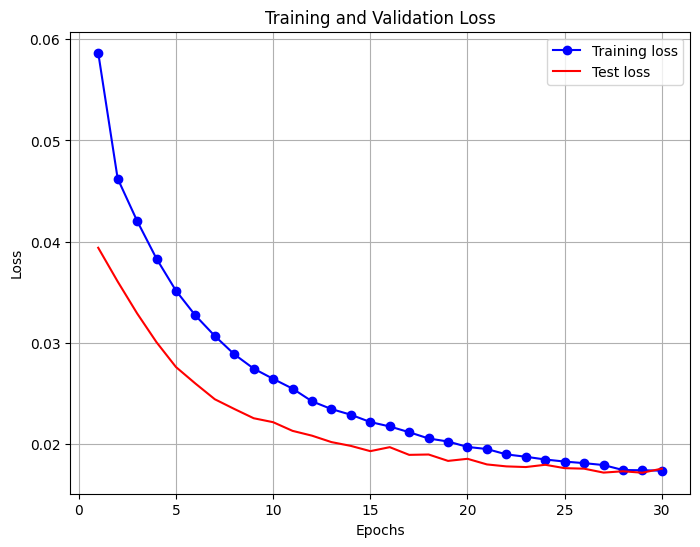

In [9]:
# Create an array of epoch numbers (1 to total epochs)
epochs_range = np.arange(epochs) + 1  

# Initialize a figure for the plot
plt.figure(figsize=(8,6))

# Plot training loss
plt.plot(epochs_range, train_loss, 'bo-', label='Training loss')  # 'bo-' → Blue circles with a line

# Plot validation loss
plt.plot(epochs_range, test_loss, 'r-', label='Test loss')  # 'r-' → Red line

# Add title and labels
plt.title('Training and Validation Loss')  # Title for the plot
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Loss')  # Label for y-axis

# Display legend to differentiate between training and validation loss
plt.legend()

# Enable grid for better visualization
plt.grid(True)

# Show the final plot
plt.show()


# **Training and Validation Loss Analysis**

### **Understanding the Graph**
The graph represents the **training loss (blue line with dots)** and **validation loss (red line)** over 30 epochs.  
- The **x-axis (Epochs)** shows the number of training cycles.
- The **y-axis (Loss)** represents the error between predicted and actual keypoints.

---

### **Key Observations**
### **Both Losses Decrease Over Time**
- The **training loss** and **validation loss** both show a downward trend, indicating that the model is **learning** and improving.
- This suggests that the model is successfully minimizing the error between predicted and ground truth keypoints.

### **No Major Overfitting**
- If overfitting occurred, we would see the **training loss decreasing sharply** while the **validation loss starts increasing** after some epochs.
- Here, both losses are decreasing at a similar rate, which means the model is **generalizing well** to unseen data.

### **Test Loss is Lower than Training Loss Initially**
- In the first few epochs, the **test loss (red line) is lower than training loss**.
- This can happen due to **regularization effects**, dropout layers, or specific patterns in the dataset.
- As training progresses, the test loss stabilizes and converges with the training loss.

### **Convergence at the End**
- Around **epoch 25-30**, both losses **stabilize at a low value**.
- This means further training might **not significantly improve the model**.

---

## **What This Means for the Model**
**Model is improving** → The loss is decreasing steadily.  
**No major overfitting** → Validation and training losses remain close.  
**Model is stable** → Losses are not fluctuating wildly.  
**Further fine-tuning may not be necessary** → The model has likely learned enough.  

---


# **Step 6: Evaluating the Model and Visualizing Predictions**

## **Why This Step?**
After training our model, we need to **evaluate its performance** by:
1. **Testing on unseen images** to see how well it generalizes.
2. **Comparing predicted keypoints with ground truth** to assess accuracy.
3. **Visualizing predictions** to ensure the model learns meaningful facial patterns.

This step is crucial to understand whether the model is correctly identifying facial keypoints or if further fine-tuning is needed.

---

## **Implementation**

### **Select Random Test Images**
```python
# Select 6 random indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), 6)
```
- Randomly selects **6 images** from the test dataset.
- Ensures we evaluate different faces, not just the ones seen during training.

### **Initialize a Figure for Visualization**
```python
# Create figure
plt.figure(figsize=(12, 6))
```
- Creates a **matplotlib figure** to plot multiple images side by side.
- The figure size is set to `(12, 6)` for a clear view.

### **Loop Through Each Selected Image**
```python
for i, ix in enumerate(random_indices):
```
- Iterates through the **randomly selected test images**.

---

### **Load and Prepare Images**
```python
    # Load Original Image (for visualization)
    im = test_dataset.load_image(ix)
    
    # Load Preprocessed Image for Model Inference
    x, _ = test_dataset[ix]  
    x = x.unsqueeze(0).to(device)  # Add batch dimension & move to GPU if available
```
- **`load_image(ix)`** loads the **original image** for visualization.
- **`test_dataset[ix]`** loads the **preprocessed image** (normalized, resized).
- **`unsqueeze(0)`** adds a **batch dimension** because models expect batch inputs.
- **`to(device)`** moves the image to GPU if available.

---

### **Predict Facial Keypoints**
```python
    # Predict Keypoints
    with torch.no_grad():  # Disable gradients for inference
        kp = model(x).flatten().detach().cpu().numpy()  # Convert to NumPy array
```
- **Disables gradient tracking (`torch.no_grad()`)** → Saves memory and speeds up inference.
- **Passes the image through the model (`model(x)`)** to predict keypoints.
- **Converts keypoints to a NumPy array (`.cpu().numpy()`)** for plotting.

---

### **Extract X and Y Coordinates**
```python
    # Extract X and Y Coordinates (Same as Dataset Class)
    kp_x = kp[0::2] * 224  # Extract X-coordinates and scale
    kp_y = kp[1::2] * 224  # Extract Y-coordinates and scale
```
- **Splits keypoints into `x` and `y` coordinates** (even indices for `x`, odd for `y`).
- **Scales them back to image size** (`* 224`) since the model outputs values between `0-1`.

---

### **Plot Original Images**
```python
    # Plot Original Image
    plt.subplot(2, 6, i + 1)  # 2 rows, 6 columns
    plt.imshow(im)
    plt.axis("off")
    plt.title("Original")
```
- Plots the **original test image**.
- `subplot(2,6,i+1)` → Places image in the **first row**.
- `axis("off")` → Removes grid and axis labels for clarity.
- `title("Original")` → Labels the image.

---

### **Plot Images with Predicted Keypoints**
```python
    # Plot Image with Predicted Keypoints
    plt.subplot(2, 6, i + 7)  # 2nd row
    plt.imshow(im)
    plt.scatter(kp_x, kp_y, c="r", s=10)  # Overlay keypoints
    plt.axis("off")
    plt.title("With Keypoints")
```
- Plots the **same image but with predicted keypoints**.
- `scatter(kp_x, kp_y, c="r", s=10)` → Marks keypoints in **red**.
- `subplot(2,6,i+7)` → Places keypoint visualization in the **second row**.

---

### **Adjust Layout and Display**
```python
plt.tight_layout()
plt.show()
```
- **`tight_layout()`** ensures all images fit well in the figure.
- **`show()`** displays the final plot.

---



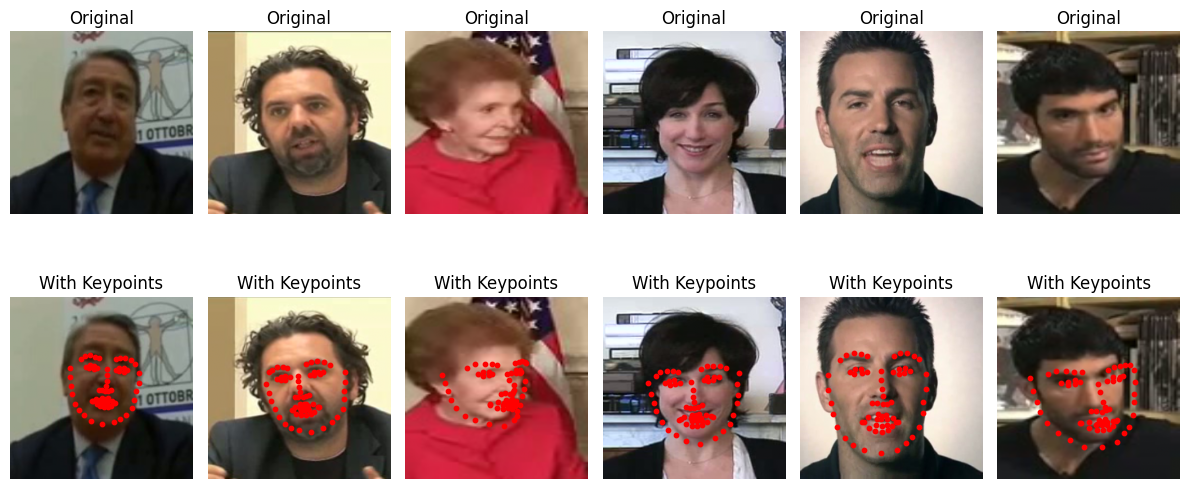

In [13]:
# Select 6 random indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), 6)

# Create figure
plt.figure(figsize=(12, 6))

for i, ix in enumerate(random_indices):
    # Load Original Image (for visualization)
    im = test_dataset.load_image(ix)

    # Load Preprocessed Image for Model Inference
    x, _ = test_dataset[ix]  
    x = x.unsqueeze(0).to(device)  # Add batch dimension & move to GPU if available

    # Predict Keypoints
    with torch.no_grad():  # Disable gradients for inference
        kp = model(x).flatten().detach().cpu().numpy()  # Convert to NumPy array

    # Extract X and Y Coordinates (Same as Dataset Class)
    kp_x = kp[0::2] * 224  # Extract X-coordinates and scale
    kp_y = kp[1::2] * 224  # Extract Y-coordinates and scale

    # Plot Original Image
    plt.subplot(2, 6, i + 1)  # 2 rows, 6 columns
    plt.imshow(im)
    plt.axis("off")
    plt.title("Original")

    # Plot Image with Predicted Keypoints
    plt.subplot(2, 6, i + 7)  # 2nd row
    plt.imshow(im)
    plt.scatter(kp_x, kp_y, c="r", s=10)  # Overlay keypoints
    plt.axis("off")
    plt.title("With Keypoints")

plt.tight_layout()
plt.show()



## Model Inference on Test Data**

## **Understanding the Image**
The image above displays the **model’s performance on unseen test data** by predicting **facial keypoints** on different faces.

- **Top Row (Original Images):**  
  - These are test images that the model has never seen before.
  - The goal is to predict key facial landmarks for each face.

- **Bottom Row (Images with Predicted Keypoints):**  
  - The red dots represent **predicted facial keypoints**.
  - These keypoints include the **eyes, nose, lips, jawline, and eyebrows**.

---

## **Key Observations**
### **Model is Detecting Facial Features Accurately**
- The model successfully identifies major facial landmarks, including:
  - **Eyebrows**
  - **Eyes**
  - **Nose**
  - **Mouth**
  - **Jawline**

- The **alignment of keypoints is generally good**, indicating that the model has learned to localize facial features effectively.

---

### **Some Keypoints Show Slight Misalignment**
- In certain images, keypoints around the **mouth and nose** are slightly off.
- Some variations can be due to:
  - **Pose differences (head tilts, rotations).**
  - **Blurry or low-resolution images.**
  - **Expressions affecting facial structure.**

- Potential improvements:
  - **More diverse training data** to handle different head poses.
  - **Data augmentation** to improve generalization.

---

### **Works Across Different Faces**
- The model generalizes well across:
  - **Different skin tones and facial structures.**
  - **Varying lighting conditions.**
  - **Different backgrounds.**
  
This indicates that the model has **learned robust facial feature extraction**.

---



# **Step 7: Saving the Trained Model**

### **Why This Step?**
After training the facial keypoint detection model, it is important to **save the trained weights** so that:
- We **don't have to retrain** the model every time.
- We can **resume training later** if needed.
- We can **deploy the model for real-time inference** without retraining.

---

### **Implementation**
```python
torch.save(model.state_dict(), "facial_keypoints_model_v2.pth")
print("Model saved successfully!")
```

### **`model.state_dict()`**
- **Extracts only the model’s trainable parameters** (weights & biases).
- Does **not save the model architecture**—only the learned values.

### **`torch.save(...)`**
- Saves the extracted weights into a file **`facial_keypoints_model_v2.pth`**.
- This file stores the numerical values of all **trained layers**.

### **Print Confirmation**
- Confirms that the model has been successfully saved.

---

## **Why Save Using `state_dict()`?**
| **Method**                 | **What It Saves?**                          | **Use Case** |
|---------------------------|--------------------------------|------------|
| `torch.save(model.state_dict(), "model.pth")` | **Only the trained parameters** (weights & biases). | Recommended for saving models. |
| `torch.save(model, "model.pth")` | **Entire model (structure + weights).** | Works but is **less flexible**—must reload with the same architecture. |

Using **`state_dict()`** ensures that:
- The model **remains lightweight**.
- We can **reload weights into different architectures** if needed.
- The saved file can be **loaded on different devices** (CPU/GPU).

---

## **Key Takeaways**
✅ **Saving prevents retraining from scratch**.  
✅ **Using `state_dict()` is efficient and flexible**.  
✅ **The model can now be deployed or further fine-tuned later**.  

```

In [11]:
torch.save(model.state_dict(), "facial_keypoints_model_v2.pth")
print("Model saved successfully!")


Model saved successfully!


# **Step 8: Loading the Saved Model for Inference**

### **Why This Step?**
After saving our trained model, we need to **load it back** for:
- **Performing inference** on new facial images.
- **Resuming training** from where we left off.
- **Deploying the model** without retraining.

Since `load_state_dict()` only saves and loads the model’s weights, we must **redefine the model architecture** before loading these weights.

---

### **Implementation**
```python
import torch
import torch.nn as nn
import torchvision.models as models

# Reinitialize the model architecture
class FacialKeypointModel(nn.Module):
    def __init__(self):
        """
        Defines a modified VGG16 model for facial keypoint detection.
        """
        super(FacialKeypointModel, self).__init__()

        # Load pre-trained VGG16 model
        self.model = models.vgg16(pretrained=True)

        # Freeze pre-trained weights
        for param in self.model.parameters():
            param.requires_grad = False

        # Modify feature extraction layers 
        self.model.avgpool = nn.AdaptiveAvgPool2d((2, 2))  

        # Define a new classifier 
        self.model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),  # 512 * 2 * 2 as previous layer will give 2*2 and we will have 2048 neurons
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 136),  # 136 keypoints (68 pairs of x, y)
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize a new model instance
model = FacialKeypointModel()

# Load the saved model state dictionary
model.load_state_dict(torch.load("facial_keypoints_model_v2.pth", map_location=device))

# Move the model to the correct device (GPU if available, otherwise CPU)
model = model.to(device)

# Set the model to evaluation mode (disables dropout, batch normalization updates, etc.)
model.eval()

# Print confirmation
print("Model loaded successfully!")
```

---

### **Understanding the Code**

### **Reinitialize the Model Architecture**
```python
class FacialKeypointModel(nn.Module):
    ...
```
- Since `state_dict` only saves the model weights, we must **define the model architecture again** before loading weights.
- This ensures that the loaded parameters match the model's expected structure.

### **Initialize an Empty Model**
```python
model = FacialKeypointModel()
```
- Creates a **new model instance** with the same architecture.

### **Load the Model's State Dictionary**
```python
model.load_state_dict(torch.load("facial_keypoints_model_v2.pth", map_location=device))
```
- **`torch.load("facial_keypoints_model_v2.pth")`** loads the saved weights.
- **`load_state_dict(...)`** applies these weights to the newly initialized model.
- **`map_location=device`** ensures that the model is loaded onto the correct device:
  - **If using a GPU**, it loads to **CUDA**.
  - **If using a CPU**, it loads to **CPU**.

### **Move Model to the Correct Device**
```python
model = model.to(device)
```
- Ensures the model runs **on GPU if available**, otherwise defaults to CPU.

### **Set Model to Evaluation Mode**
```python
model.eval()
```
- **Disables dropout layers** (which are only needed during training).
- **Ensures stable performance** for inference.

### **Confirm Model is Loaded**
```python
print("Model loaded successfully!")
```
- Displays a message to confirm that the model is ready.

---

### **Why `eval()` is Necessary?**
`model.eval()` **switches the model to inference mode**, which:
- **Disables dropout** (ensuring consistent predictions).
- **Freezes batch normalization statistics**, preventing unwanted updates.

Using `eval()` ensures that predictions are **accurate and reliable**.

---

### **Why We Need to Reinitialize the Model?**
| **Action** | **Reason** |
|------------|-----------|
| **Saving only `state_dict()`** | Saves **only weights**, not architecture. |
| **Reinitializing the model** | Ensures the model structure matches the saved weights. |
| **Loading weights into the model** | Transfers the learned parameters into the newly created model instance. |

---


**Reinitializing the model is necessary before loading weights**.  
**Using `state_dict()` is efficient and flexible for saving/loading models**.  
**Calling `model.eval()` ensures proper inference behavior**.  

With our model successfully loaded, we can now **use it to predict facial keypoints on new images**.
```

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

# Reinitialize the model architecture
class FacialKeypointModel(nn.Module):
    def __init__(self):
        """
        Defines a modified VGG16 model for facial keypoint detection.
        """
        super(FacialKeypointModel, self).__init__()

        # Load pre-trained VGG16 model
        self.model = models.vgg16(pretrained=True)

        # Freeze pre-trained weights
        for param in self.model.parameters():
            param.requires_grad = False

        # Modify feature extraction layers 
        self.model.avgpool = nn.AdaptiveAvgPool2d((2, 2))  

        # Define a new classifier 
        self.model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),  # 512 * 2 * 2 as previous layer will give 2*2 and we will have 2048 neurons
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 136),  # 136 keypoints (68 pairs of x, y)
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize a new model instance
model = FacialKeypointModel()

# Load the saved model state dictionary
model.load_state_dict(torch.load("facial_keypoints_model_v2.pth", map_location=device))

# Move the model to the correct device (GPU if available, otherwise CPU)
model = model.to(device)

# Set the model to evaluation mode (disables dropout, batch normalization updates, etc.)
model.eval()

# Print confirmation
print("Model loaded successfully!")

/home/arsalan/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/arsalan/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully!


/tmp/ipykernel_6226/3007932800.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("facial_keypoints_model_v2.pth", map_location=device))


# **Final Thoughts**
**Model successfully predicts facial keypoints on test images.**  
**Keypoints align well with actual facial structures.**  
**Some minor misalignments suggest areas for fine-tuning.**  

